## Importing Data & Exploration

In [376]:
# Imports should be grouped in the following order:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from statsmodels.formula.api import ols

%matplotlib inline
plt.style.use('fivethirtyeight')

In [332]:
np.random.seed(3)

In [333]:
kc_housing = pd.read_csv('kc_house_data.csv')
kc_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [334]:
kc_housing.isna().sum(), kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


(id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront       2376
 view               63
 condition           0
 grade               0
 sqft_above          0
 sqft_basement       0
 yr_built            0
 yr_renovated     3842
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 dtype: int64, None)

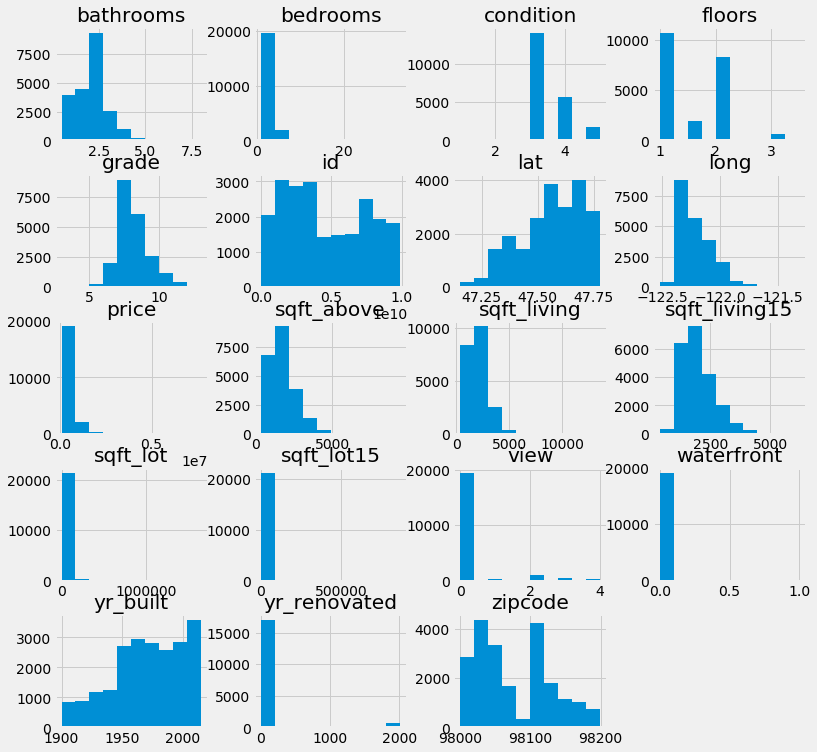

In [335]:
_ = kc_housing.hist(figsize=(12,12))

In [336]:
potential_cols = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors',
                     'waterfront', 'view','condition','grade','sqft_above','sqft_basement',
                     'sqft_living15','sqft_lot15']
    
# _ = pd.plotting.scatter_matrix(kc_housing[potential_cols], figsize=(12,12))

### Scrubbing our data

#### Notes on data cleaning and organizing:
Dropping for now:
* Id: Does not feel necessary for our exploration and will drop this column
* Latitude & Longitude: for location purses, we are going to do some exploring with the ZIP code.
* Date: Going to use for some computations, but not do not need the variable on its own.

In [337]:
kc_measures = kc_housing.drop(['id','date','sqft_above','lat','long'], axis=1).copy()

Cleaning NaN values:
* Waterfront: data is both incomplete and appears to be very skewed. Since the value is already binary, we are marking all the NaN values negative for the time being to see if it provides any detail.
* Yr_renovated: To handle missing values, collapsing into binary for denoting renovation (True), or no value (False)
* Sqft_above: With ample other features for our property size, we decided to pass on using the characteristic for the time being. 
* Yr_built: this value on its own is not as helpful, but will use for some computation, so dropping for now.

In [338]:
kc_measures['waterfront'] = kc_measures['waterfront'].fillna(0.0)

kc_measures['renovated'] = np.where(kc_measures['yr_renovated']>0, 1, 0) 
kc_measures.drop('yr_renovated', axis=1, inplace=True)

kc_measures['view'] = kc_measures['view'].dropna(axis=0)
kc_measures['view'] = np.where(kc_measures['view']> 0, 1, 0)

Other data errors:
* Sqft_basement: In exploring this column, we found that some were marked with a question mark instead of a value. It appears that this column was a computation from sqft_living. Our decision was to test this variable as a binary value equating to having a basement(True), or no basement listed (False)

In [339]:
kc_measures['sqft_basement'] = kc_measures['sqft_basement'].str.replace('?', '0.0').astype('float')

In [340]:
kc_measures['basement'] = np.where(kc_measures['sqft_basement'] > 0, 1, 0)
kc_measures.drop('sqft_basement', axis=1, inplace=True)

Potential solutions for ZIP Code:
* Creating dummy variables for each individual ZIP code. This may subdivide things too much, but can expirment with it. 
* Trying a simple binary "In Seattle"-> True, "Not Seattle"-> False. A slimmer option, but might not provide the subltey of neighborhood variation.

In [428]:
df_zipcode_dums = pd.get_dummies(kc_measures['zipcode'])
kc_measures_wzip = pd.concat([kc_measures, df_zipcode_dums], axis=1)

In [343]:
# seattle_zips = [98101, 98102, 98104, 98105, 98108, 98109, 98112, 98113, 98114, 98117, 98103, 98106, 98107,
#                 98111, 98115, 98116, 98118, 98119,98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 
#                 98122, 98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148, 98155, 98160, 98161, 
#                 98164, 98165, 98168, 98170, 98146, 98154, 98158, 98166, 98174, 98175, 98178, 98190, 98191,
#                 98177, 98181, 98185, 98188, 98189, 98194, 98195, 98199,98198]

In [344]:
# kc_measures['in_seattle'] = kc_measures['zipcode'].map(lambda x: 1 if x in seattle_zips else 0)
# kc_measures.drop('zipcode', axis=1, inplace=True)

Potential uses of Year Built:
* Creating scalar values for column values for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built

In [345]:
kc_measures['yr_built_scalar_1899refyr'] = kc_measures['yr_built'].apply(lambda x: abs(1899-x))
kc_measures.drop('yr_built', axis=1, inplace=True)

Further notes:
* Bedrooms: The data appears complete, though has some heavy outliers on the higher end (one with 33 bedrooms!) which may need to be min-max standardized
* Bathrooms: Comporable to bedrooms, may need to be adjusted for outliers, but complete.
* Yr_built: To make this column more useful, we are going to convert it into its age in years (subtract current year)
* Yr_renovated: data is fairly incomplete, so might want to skip
* Sqft Living 15: Based on the graphs, it looks like we might find some helpful relationship
* Maybe yard size? Sqft_living - sqft_lot

In [346]:
kc_measures.columns
# Change name - yr_renovated_new',  'waterfront_new',  'view_new',

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'renovated', 'basement', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [347]:
# Test for location close to expensive areas
# kc_measures['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_measures.drop(['lat','long'], axis=1, inplace=True)
# # location = (lat + 90) * 180 + long

In [348]:
# downtown = (47.60806 + 90) * (180 + -122.33611)
# madrona = (47.613274 + 90) * (180 + -122.28887)
# slu = (47.62343 + 90) * (180 + -122.33435)
# eastlake = (47.64708 + 90) * ( 180 + -122.32477)
# queen_anne = (47.63692 + 90) * (180 + -122.35579)
# magnolia = (47.65056 + 90) * (180 + -122.40083)
# first_hill = (47.60864 + 90) *(180 + -122.32679)

# # #location = (lat + 90) * 180 + long

# kc_expensive = kc_housing.drop(['id','date','sqft_above'], axis=1).copy()
# kc_expensive['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_expensive['loc_downtown'] = kc_expensive['loc'].apply(lambda x: x - downtown)
# kc_expensive['loc_madrona'] = kc_expensive['loc'].apply(lambda x: x - madrona)
# kc_expensive['loc_slu'] = kc_expensive['loc'].apply(lambda x: x - slu)
# kc_expensive['loc_eastlake'] = kc_expensive['loc'].apply(lambda x: x - eastlake)
# kc_expensive['loc_queen_anne'] = kc_expensive['loc'].apply(lambda x: x - queen_anne)
# kc_expensive['loc_magnolia'] = kc_expensive['loc'].apply(lambda x: x - magnolia)
# kc_expensive['loc_first_hill'] = kc_expensive['loc'].apply(lambda x: x - first_hill)

### Potential modelling based around categories of information:

* Size - sqft_living, sqft_lot, sqft_above, basement, sqft_lot15, sqft_living15, sqft
* Structure - bedrooms, bathrooms, floors, waterfront, view, condition, grade, renovated, basement
* Location - zipcode

In [ ]:
  len_X_columns = len(X.columns)
    print(f"{len_X_columns} Features included in model: {X.columns.sort_values()}")

In [426]:
def lin_regress_summary(kc):
    """ define input X and y, fit OLS model, output model eval metrics"""
    
    # defines features and target passed to tts/model
    X = kc.drop(['price'], axis=1)
    y = kc.price

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test

    # See the R Squared score for our test data
    r2 = r2_score(y_test, y_hat_test)
    print(f"the r2 score is: {r2}")

    # See our Squared Mean Error score for data
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    test_mse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_mse}")
    
    test_mae = mean_absolute_error(y_test, y_hat_test)
    print(f"the test MAE is: {test_mae}")
    
    #TODO (Lee) - turn the statsmodel output into an optional argument?
    model_1 = sm.OLS(y, X)
    results = model_1.fit()
    print(results.summary())
    
    # produces qqplot of y-hat from statmodel model
    resid1 = results.resid
    print(f"qqplot of yhat from stasmodel model")
    fig = sm.graphics.qqplot(resid1, line='45', fit=True)
    fig.show()
    
    # k-fold cross-val on X_train and y_train
    cv_10_results_10_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error"))))
    print(f"k-fold cross val 10 RMSE: {cv_10_results_10_RMSE}")
    
    cv_10_results_10_MSE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))
    print(f"k-fold cross val 10 MSE: {cv_10_results_10_MSE}")
    
    cv_10_results_10_MAE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_absolute_error")))
    print(f"k-fold cross val 10 MAE: {cv_10_results_10_MAE}")

### separates linreg function into individual functions

In [ ]:
def define_x_y(pass)
    """defines features and target passed to tts/model"""
    X = kc.drop(['price'], axis=1)
    y = kc.price
    len_X_columns = len(X.columns)
    print(f"{len_X_columns} Features included in model: {X.columns.sort_values()}")

In [ ]:
def crossval_technique(x, y, test_size)
    """ Create train-test split """
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    print((f"cross-val technique is:  Features included in model: {X.columns.sort_values()}")

In [ ]:
def model_fit(pass)
    """Create model"""
    model = LinearRegression()
    model.fit(X_train, y_train)

In [ ]:
def calculate_y_hat()
    """ Calculate our y hat (how our model performs against the test data held off)"""
    y_hat_test = model.predict(X_test)
    y_hat_test

In [ ]:
def calculate_model_eval_metrics(pass)
    """prints model eval metric"""
    # See the R Squared score for our test data
    r2 = r2_score(y_test, y_hat_test)
    print(f"the r2 score is: {r2}")

    # See our Squared Mean Error score for data
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    test_mse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_mse}")
    
    test_mae = mean_absolute_error(y_test, y_hat_test)
    print(f"the test MAE is: {test_mae}")

In [ ]:
def 
    """defines features and target passed to tts/model"""
    X = kc.drop(['price'], axis=1)
    y = kc.price
    len_X_columns = len(X.columns)
    print(f"{len_X_columns} Features included in model: {X.columns.sort_values()}")

In [ ]:
def statsmodel_workflow(pass)
# TODO (Lee) - turn the statsmodel output into an optional argument?
    #model = sm.OLS(y, X)
    #results = model.fit()
    #print(results.summary())

In [ ]:
def model_packaged_summary(kc, crossval_params):
    """workflow pipeline/packaging to define input X and y, fit OLS model, output model eval metrics"""
    
    # a = define_x_y(kc)
    x = define_x(kc)
    y = define_y(kc)
    
    b = crossval_technique(x, y, 0.2)
    
    c = model_fit(b)

    d = calculate_y_hat(c)
    
    e = calculate_model_eval_metrics(d)

    return e

the r2 score is: 0.6501529013795871
the test MSE is: 49357384547.92217
the test RMSE is: 222165.2190328679
the test MAE is: 141103.9189389415
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:09:37   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:                   21582   BIC:                         5.921e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


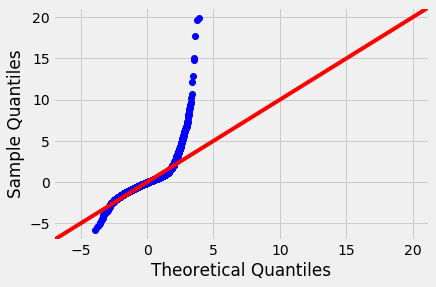

In [427]:
# TODO (Lee) - print in output: name/attributes of y column inputted to model
# TODO (Lee) - debug the varying outputs if run this model repeatedly
mod_test = lin_regress_summary(kc_measures)

In [356]:
lin_regress_summary(kc_measures_wzip)

TypeError: '<' not supported between instances of 'int' and 'str'

In [47]:
kc_m_update1 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'floors','view', 'condition',
                            'grade','sqft_living15', 'sqft_lot15']]

In [161]:
type(statsmodel_model)

NameError: name 'statsmodel_model' is not defined

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6541364585036736
the test MSE is: 49141402368.06891
the test RMSE is: 221678.60151144248
the test MAE is: 137888.09788966278
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:26:32   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:             

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


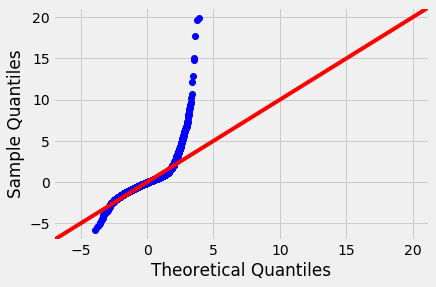

In [318]:
lin_regress_summary(kc_m_update1)

In [319]:
kc_m_update2 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade',
                            'zipcode', 'sqft_living15','sqft_lot15', 'renovated',
                            'basement', 'yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6622569170298012
the test MSE is: 43015122559.49486
the test RMSE is: 207400.87405672827
the test MAE is: 141153.1977704936
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:26:44   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:              

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


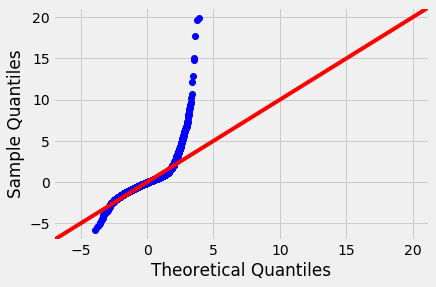

In [320]:
lin_regress_summary(kc_m_update2)

In [321]:
kc_m_update3 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade', 'zipcode',
                            'sqft_living15','sqft_lot15',  'basement', 'yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6483564887051567
the test MSE is: 46561221536.93135
the test RMSE is: 215780.49387498247
the test MAE is: 139574.09624227337
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:26:56   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:             

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


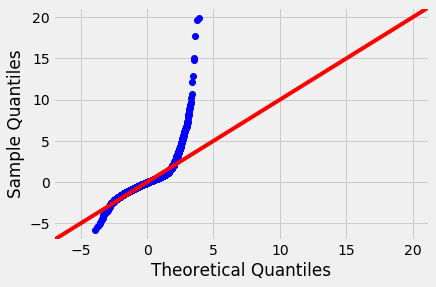

In [322]:
lin_regress_summary(kc_m_update3)

In [323]:
kc_m_update4 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot','view', 'condition', 'grade', 'sqft_living15',
                               'sqft_lot15','yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6721685809241912
the test MSE is: 45152190807.0519
the test RMSE is: 212490.44874311858
the test MAE is: 139566.14616490525
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:27:13   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:              

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


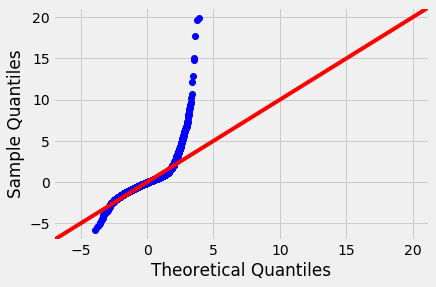

In [324]:
lin_regress_summary(kc_m_update4)

In [325]:
kc_m_update5 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view',  'grade', 'sqft_living15',
                               'sqft_lot15', 'yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6700890462882532
the test MSE is: 41972993394.39962
the test RMSE is: 204873.11535289255
the test MAE is: 139702.97622506105
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:27:21   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:             

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


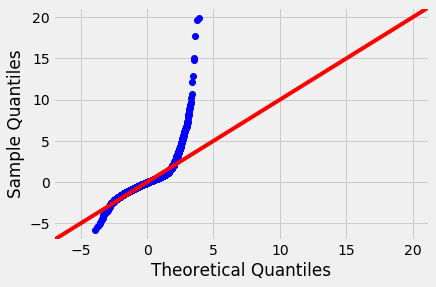

In [326]:
lin_regress_summary(kc_m_update5)

In [327]:
kc_m_update6 = kc_measures[['price','bedrooms', 'bathrooms', 'sqft_living',
                            'condition', 'grade','basement', 'waterfront', 'view']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6465979362081258
the test MSE is: 47996323701.96597
the test RMSE is: 219080.6328774088
the test MAE is: 140433.20911886383
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:27:30   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:              

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


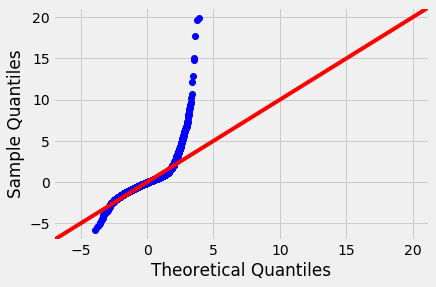

In [328]:
lin_regress_summary(kc_m_update6)

In [429]:
kc_use = kc_measures[['price','waterfront', 'view', 'floors',
                      'sqft_living', 'grade', 'yr_built_scalar_1899refyr']]
kc_m_update7 = pd.concat([kc_use, df_zipcode_dums], axis=1)

the r2 score is: 0.7887650140210343
the test MSE is: 28857117523.369972
the test RMSE is: 169873.8282472317
the test MAE is: 100407.97185510705
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1115.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:17:43   Log-Likelihood:            -2.9026e+05
No. Observations:               21597   AIC:                         5.807e+05
Df Residuals:                   21521   BIC:                         5.813e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


k-fold cross val 10 RMSE: 165872.4343359883
k-fold cross val 10 MSE: 27854886985.88441
k-fold cross val 10 MAE: 99794.93942292478


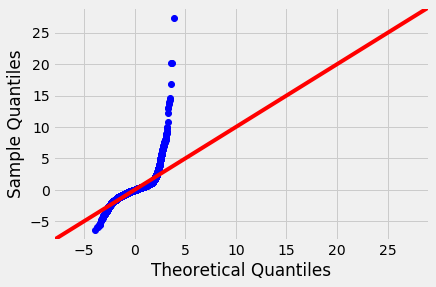

In [430]:
lin_regress_summary(kc_m_update7)

the r2 score is: 0.866340137793201
the test MSE is: 0.0375035245233755
the test RMSE is: 0.19365826737677763
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1815.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:32:45   Log-Likelihood:                 4709.8
No. Observations:               21597   AIC:                            -9268.
Df Residuals:                   21521   BIC:                            -8661.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


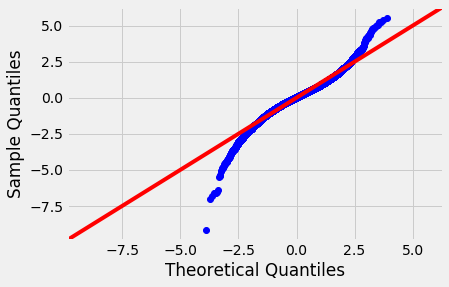

In [499]:
lin_regress_logprice_summary(kc_m_update7)

In [265]:
kc_use = kc_measures[['price','sqft_living','bedrooms','bathrooms',
                      'grade', 'sqft_lot']]
kc_m_update8 = pd.concat([kc_use, df_zipcode_dums], axis=1)

In [266]:
lin_regress_summary(kc_m_update8)

the r2 score is: 0.74038834595689
the test MSE is: 40613086115.20476
the test RMSE is: 201526.88682953638
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     876.6
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:08   Log-Likelihood:            -2.9238e+05
No. Observations:               21597   AIC:                         5.849e+05
Df Residuals:                   21522   BIC:                         5.855e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [267]:
kc_size = kc_measures[['price','sqft_living','sqft_lot','sqft_living15','sqft_lot15']]

In [268]:
lin_regress_summary(kc_size)

the r2 score is: 0.48706870232512056
the test MSE is: 67992862746.98016
the test RMSE is: 260754.41079103563
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 2.838e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:08   Log-Likelihood:            -3.0002e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21593   BIC:                         6.001e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [269]:
kc_structure = kc_measures[['price','bedrooms', 'bathrooms','floors',
                           'waterfront','view','condition', 'grade',
                           'renovated','basement']]

In [270]:
lin_regress_summary(kc_structure)

the r2 score is: 0.542610991732333
the test MSE is: 63208628350.04705
the test RMSE is: 251413.26208067674
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 1.130e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:09   Log-Likelihood:            -3.0101e+05
No. Observations:               21597   AIC:                         6.020e+05
Df Residuals:                   21588   BIC:                         6.021e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

### Model fit testing

In [271]:
import statsmodels.api as sm

def stepwise_selection(df, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    y = df['price']
    X = df.drop('price', axis=1)
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [272]:
# exploratory stepwise_selection of kc_m_update7 model
stepwise_selection(kc_m_update7)

Add  floors                         with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop floors                         with p-value 0.0652283


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  waterfront                     with p-value 0.0
Add  grade                          with p-value 0.0
Add  yr_built_scalar_1899refyr      with p-value 0.0
Add                           98004 with p-value 0.0
Add                           98039 with p-value 1.4585e-293
Add                           98112 with p-value 9.1631e-143
Add                           98040 with p-value 1.59767e-151
Add  view                           with p-value 4.66038e-121
Add                           98033 with p-value 7.28967e-104
Add                           98023 with p-value 4.26657e-96
Add                           98105 with p-value 1.85388e-67
Add                           98092 with p-value 1.01053e-60
Add                           98119 with p-value 4.86705e-60
Add                           98103 with p-value 1.48949e-63
Add                           98115 with p-value 2.21566e-65
Add                           98199 with p-value 3.90015e-70
Add                           98117 with p-value 4.17

['sqft_living',
 'waterfront',
 'grade',
 'yr_built_scalar_1899refyr',
 98004,
 98039,
 98112,
 98040,
 'view',
 98033,
 98023,
 98105,
 98092,
 98119,
 98103,
 98115,
 98199,
 98117,
 98102,
 98109,
 98107,
 98006,
 98122,
 98116,
 98144,
 98052,
 98003,
 98005,
 98053,
 98008,
 98034,
 98042,
 98001,
 98198,
 98058,
 98030,
 98038,
 98031,
 98178,
 98022,
 98032,
 98136,
 98055,
 98002,
 98166,
 98188,
 98070,
 98168,
 98177,
 98029,
 98007,
 98125,
 98126,
 98075,
 98074,
 98027,
 'floors',
 98133,
 98118,
 98024,
 98072,
 98155]

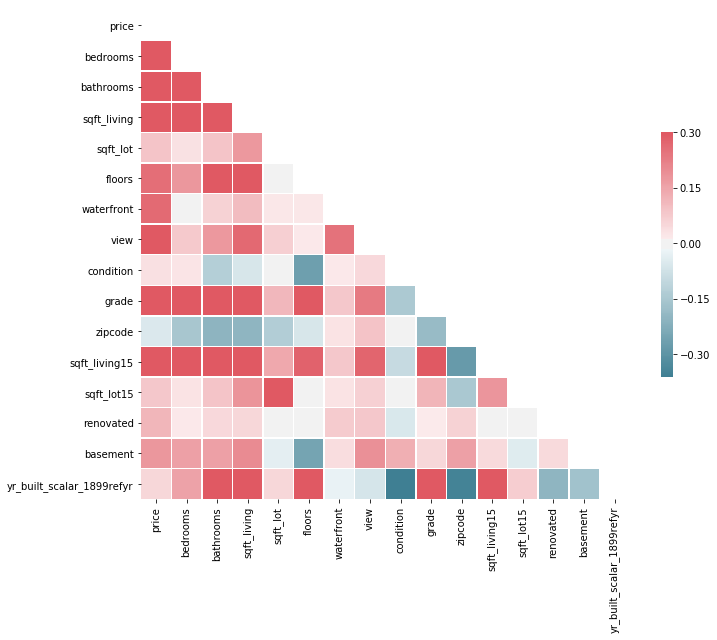

In [273]:
corr = kc_measures.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Looking for multicolinearity

From: https://seattle.curbed.com/2017/10/11/16462132/seattle-cheap-expensive-neighborhoods-buying-home

In [274]:
from sklearn import preprocessing
import statsmodels.api as sm

### Multivariate Linear Regression Models (Normalized just with Standard scalar, but not train-test split)

In [275]:
def ml_summary(df):
    
    scaler = preprocessing.StandardScaler()
    np_scaled = scaler.fit_transform(df)
    df_normalized = pd.DataFrame(np_scaled, columns=df.columns)
    
    y = df_normalized['price']
    X = df_normalized.drop('price', axis=1)
    
    predictors_int = sm.add_constant(X)
    model = sm.OLS(y, predictors_int).fit()
    print(model.summary())

### Plotting practice

(array([2.180e+02, 1.457e+03, 3.089e+03, 3.271e+03, 3.056e+03, 2.419e+03,
        2.034e+03, 1.464e+03, 1.157e+03, 8.880e+02, 5.930e+02, 4.180e+02,
        2.380e+02, 1.740e+02, 1.770e+02, 1.350e+02, 1.320e+02, 9.100e+01,
        8.100e+01, 7.900e+01, 4.200e+01, 6.600e+01, 3.800e+01, 4.000e+01,
        2.900e+01, 1.900e+01, 7.000e+00, 2.300e+01, 1.800e+01, 1.600e+01,
        1.500e+01, 1.700e+01, 1.200e+01, 5.000e+00, 8.000e+00, 4.000e+00,
        5.000e+00, 1.000e+01, 7.000e+00, 7.000e+00, 6.000e+00, 0.000e+00,
        6.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

(array([1.500e+01, 5.900e+01, 2.580e+02, 5.230e+02, 8.350e+02, 1.069e+03,
        1.248e+03, 1.388e+03, 1.480e+03, 1.479e+03, 1.421e+03, 1.416e+03,
        1.268e+03, 1.215e+03, 1.052e+03, 9.540e+02, 8.690e+02, 8.030e+02,
        6.240e+02, 5.430e+02, 4.880e+02, 4.520e+02, 3.340e+02, 3.370e+02,
        2.220e+02, 2.030e+02, 1.790e+02, 1.350e+02, 1.180e+02, 1.130e+02,
        9.200e+01, 6.600e+01, 5.900e+01, 3.200e+01, 3.100e+01, 2.900e+01,
        2.300e+01, 2.600e+01, 1.900e+01, 1.800e+01, 9.000e+00, 1.900e+01,
        7.000e+00, 9.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 5.000e+00,
        1.000e+00, 4.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 5.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

(array([1.8859e+04, 1.1760e+03, 6.8200e+02, 2.2600e+02, 1.0600e+02,
        8.0000e+01, 7.5000e+01, 3.7000e+01, 2.4000e+01, 2.3000e+01,
        1.9000e+01, 2.9000e+01, 5.9000e+01, 7.7000e+01, 1.7000e+01,
        1.5000e+01, 1.3000e+01, 9.0000e+00, 4.0000e+00, 8.0000e+00,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 7.0000e+00, 2.0000e+00,
        6.0000e+00, 1.0000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        5.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

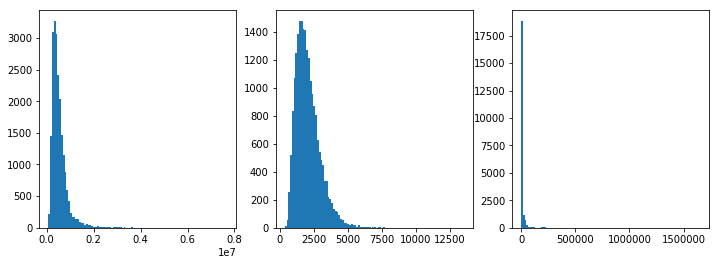

In [276]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].hist(kc_measures['price'], bins=100)
ax[1].hist(kc_measures['sqft_living'], bins=100)
ax[2].hist(kc_measures['sqft_lot'], bins=100)
plt.show()

### Basic single linear model w/train-test split

In [277]:
scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(kc_measures[['sqft_living']])
y = scaler.fit_transform(kc_measures[['price']])

In [278]:
#Linear regression with SKLearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [279]:
# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [280]:
# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = linreg.predict(X_test)

In [281]:
 # See the R Squared score for on our test data
r2 = r2_score(y_test, y_hat_test)

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
print(f"RMSE: {test_mse}\nR2: {r2}")

RMSE: 0.5095794761708107
R2: 0.4824189247395204


Text(0.5,1,'Sqft_living v. Price')

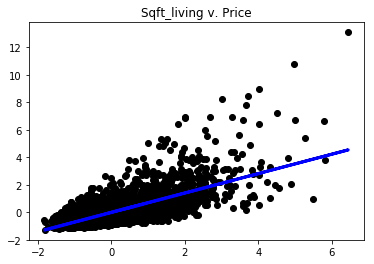

In [282]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(X_test, y_test,  color='black')
ax.plot(X_test, y_hat_test, color='blue', linewidth=3)
ax.set_title('Sqft_living v. Price')
plt.show()

Setting up a shared repo
- Add contributor, 
- git clone, git checkout -b "directory" <- creates branch

In [283]:
result = stepwise_selection(kc_measures, verbose = True)
print('resulting features:')
print(result)

Add  bedrooms                       with p-value 0.0
Add  view                           with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Drop bedrooms                       with p-value 0.429434
Add  grade                          with p-value 0.0
Add  yr_built_scalar_1899refyr      with p-value 0.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  sqft_living                    with p-value 0.0
Add  waterfront                     with p-value 4.65029e-298
Add  bedrooms                       with p-value 8.59314e-78
Add  sqft_lot15                     with p-value 2.32979e-25
Add  condition                      with p-value 4.91628e-12
Add  floors                         with p-value 2.24328e-13
Add  renovated                      with p-value 0.000874365
Add  basement                       with p-value 0.00897782
resulting features:
['view', 'bathrooms', 'sqft_living15', 'grade', 'yr_built_scalar_1899refyr', 'sqft_living', 'waterfront', 'bedrooms', 'sqft_lot15', 'condition', 'floors', 'renovated', 'basement']


* Need to check for multicollinearity 
* Seeing effect of outliers
* What about a location makes it more valuable than others, dummy for zip codes 
* Dollar per square foot
* Distance from Seattle, convert into single value by Lat-Long, calculate distance from 
* Potentially convert scale based to improve values
* When normalizing, don't lose track of the values and what they mean
* NBDime - needed to merge Jupyter notebooks
* R squared is for representation of data, but not generalize, look at test error, RMSE, MAE, RMSLE, pick baseline error, pick metric based on business problem. 
* model.score is good for getting RMSE, but don't limit yourself to that
* Cross validation will answer the question of whether to use more or less of a value
* Stick with RMSE Sklearn, feature selection 

In [498]:
def lin_regress_logprice_summary(kc):

    X = kc.drop(['price'], axis=1)
    y = np.log(kc.price)

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test

    # See the R Squared score for our test data
    r2 = r2_score(y_test, y_hat_test)
    print(f"the r2 score is: {r2}")

    # See our Squared Mean Error score for data
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    test_mse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_mse}")
    
    #TODO (Lee) - turn the statsmodel output into an optional argument?
    model_1 = sm.OLS(y, X)
    results = model_1.fit()
    print(results.summary())
    
    # produces qqplot of y-hat from statmodel model
    resid1 = results.resid
    print(f"qqplot of yhat from stasmodel model")
    fig = sm.graphics.qqplot(resid1, line='45', fit=True)
    fig.show()

In [285]:
# k-fold cross validation

In [536]:
kc_m_update7.head()

,price,waterfront,view,floors,sqft_living,grade,yr_built_scalar_1899refyr,98001,98002,98003,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,221900.0,0.0,0,1.0,1180,7,56,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,0.0,0,2.0,2570,7,52,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,0.0,0,1.0,770,6,34,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.0,0,1.0,1960,7,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,0.0,0,1.0,1680,8,88,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [400]:
X_kfold = kc_m_update7.drop('price', axis=1)

In [401]:
y_kfold = kc_measures['price']

In [402]:
linreg = LinearRegression()

In [403]:
cv_5_results_1 = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=5), scoring="neg_mean_squared_error")

cross_val_score(linreg, X_kfold, y_kfold, cv=10, scoring="neg_mean_squared_error")

TypeError: mean() got an unexpected keyword argument 'scoring'

In [375]:
cv_5_results_1

NameError: name 'cv_5_results_1' is not defined

In [382]:
cv_5_results_2 = (cross_val_score(linreg, X_kfold, y_kfold, cv=5))

In [383]:
cv_5_results_2

array([0.78107021, 0.77763334, 0.78938226, 0.80759529, 0.80230218])

In [404]:
cross_val_score(linreg, X_kfold, y_kfold, cv=10, scoring="neg_mean_squared_error")

array([-3.27671376e+10, -3.28474717e+10, -2.38698852e+10, -3.88941479e+10,
       -2.48364086e+10, -2.42445771e+10, -2.40489475e+10, -2.44676701e+10,
       -2.87333004e+10, -2.57610663e+10])

In [414]:
cv_10_results_1 = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=10, scoring="neg_mean_squared_error"))

In [415]:
cv_10_results_1

-28047061246.09373

In [416]:
cv_10_results_2 = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=10))

In [417]:
cv_10_results_2

0.7922938471311418

In [406]:
cv_20_results = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=20, scoring="neg_mean_squared_error"))

In [407]:
print(np.mean(np.sqrt(abs(cv_5_results))))
print(np.mean(np.sqrt(abs(cv_10_results))))
print(np.mean(np.sqrt(abs(cv_20_results))))

0.8896930244478403
167472.568637654
167260.11379546276


In [ ]:
# k-fold cross-val on X_train and y_train
    cv_10_results_10_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error"))))
    print(f"k-fold cross val 10 RMSE: {cv_10_results_10_RMSE}")
    
    cv_10_results_10_MSE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))
    print(f"k-fold cross val 10 MSE: {cv_10_results_10_MSE}")
    
    cv_10_results_10_MAE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_absolute_error")))
    print(f"k-fold cross val 10 MAE: {cv_10_results_10_MAE}")l

In [296]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [297]:
pd.set_option('display.max_rows', 500)

In [298]:
# kc_measures_kc_housing.drop(['id','date','sqft_above','lat','long'], axis=1).copy()

In [299]:
kc_housing.date.dtype

dtype('O')

In [300]:
kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


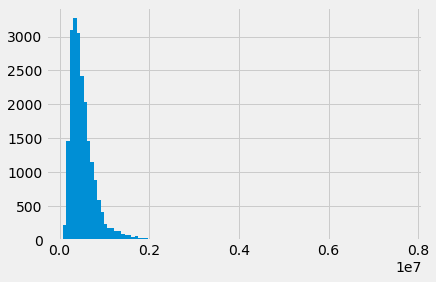

In [479]:
X = kc_measures.price.hist(bins=100)

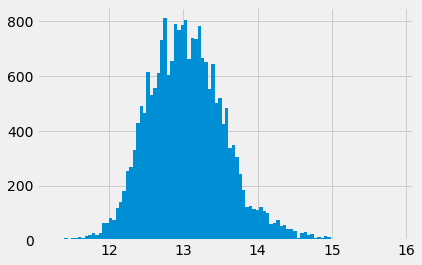

In [480]:
# natural log (logarithm in base e) is the inverse of the exponential function, so that log(exp(x)) = x
X_log = (np.log(kc_measures.price).hist(bins=100))

Text(0.5,1,'Figure 2: log-transformed target (price column)')

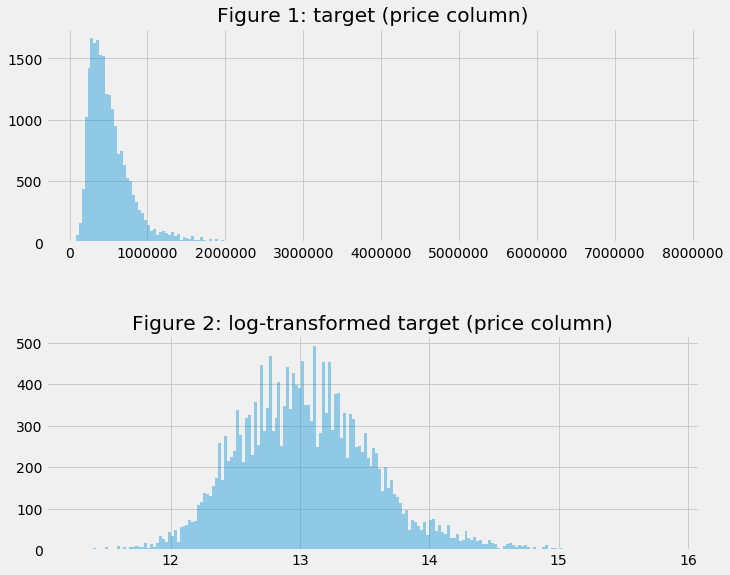

In [591]:
X = kc_measures.price
X_log = np.log(kc_measures.price)
X = kc_measures.price

fig, ax = plt.subplots(2, 1, figsize=(10,8))
fig.tight_layout(h_pad=5)
grid = plt.GridSpec(2, 1, hspace=10)

# kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
ax[0].hist(X, bins=200, alpha=0.4)
ax[1].hist(X_log, bins=200, alpha=0.4)
ax[0].set_title('Figure 1: target (price column)')
ax[1].set_title('Figure 2: log-transformed target (price column)')
# fig.tight_layout()

# plt.show()
# ax.hist(X_log) # histtype='stepfilled', bins=100, label=['log_X'])
# plt.hist(x1, histtype='stepfilled', alpha=0.3, normed=True, bins=40)
# histtype='stepfilled'

- R-square shows the amount of variance of y explained by X. In
this case our model explains ??% of the variance in price.

- Root MSE: root mean squared error, is the standard deviation of the regression. The closer to zero better the fit. 
    
- Adj R2 shows the same as R squared, but adjusted by the # of cases and # of variables.
    - When the # of variables is small and the # of cases is very large then Adj R2 is closer to R2. This provides a more honest association between X and Y than r squared.
    
- coefficie
For each unit increase in expense, price increases/decreases by "coef" units.

- p-values (wo-tail) test the hypothesis that each coefficient is different from 0. To reject this, the p-value has to be lower than 0.05. In this case, we retained features that were statistically significant in explaining price.

t-values test the hypothesis that the coefficient is different from 0. To reject this, you need a t-value greater
than 1.96 (for 95% confidence). You can get the t-values by dividing the coefficient by its standard error. The t values also show the importance of a variable in the model.